# Day 2: Automatic differentiation, and introduction to CUDA

## Automatic differentiation

Having knowledge of the gradients of a multivariable function with respect to its arguments is a powerful tool in mathematical computations, e.g., in
- computing Hessians for optimization problems or extracting uncertainties in a likelihood:
$$\begin{bmatrix} \frac{\delta^2 f}{\delta x_1^2} & \frac{\delta^2 f}{\delta x_1 \delta x_2} \\ \frac{\delta^2 f}{\delta x_1 \delta x_2} & \frac{\delta^2 f}{\delta x_2^2} \end{bmatrix}$$
- computing gradients to find descent to minimum loss in machine learning:
$$\vec{x}_{n+1} = \vec{x}_n - \gamma \nabla L(\vec{x})|_{\vec{x}=\vec{x}_n}$$


There are several ways to compute gradients:
- Use symbolic language that maps function names to their definitions and other functions for derivatives. Here is an example using Mathematica:
![Derivatives in Mathematica](mathematica_screnshot_diff.png)
- Use numerical differentiation with small step sizes.
- Embed differentials into variable definitions in programming (**automatic differentiation** - topic of today!).

Suppose we have a function $f(g(h(x)))$. The chain rule gives us
$$v=h(x)$$
$$u=g(v)$$
$$y=f(u)$$
$$\frac{\delta f}{\delta x} = \frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x}$$

This gives us two directions from which we can start differentiation:
- Forward: $\frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x} \leftarrow$ start computing derivatives in this direction.
- Reverse: start computing derivatives in this direction $\rightarrow \frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x}$.

Why does it matter? Don't we have the same number of derivatives?

$\rightarrow$ That is correct, but for a function $f: U^n \to V^m$, we would have a different number of matrix multiplication steps (derivatives $\equiv$ Jacobian matrices). For the sake of example, assume the dimensionality $k$ for both $g$ and $h$. Then,
- forward differentiation involves $(n \times k^2) + (n \times k \times m)$ multiplications, whereas
- reverse differentiation would need $(m \times k^2) + (n \times k \times m)$ multiplications.

If $n \cong m$, or $k$ is not large compared to $n$ or $m$, the direction does not matter much. On the other hand, if $k$ is large, it is better to use forward differentiation for $n \ll m$, and reverse differentiation otherwise.

In a typical neural network, gradient descent uses *forward propagation* to calculate the cost for a given loss function , and *backpropagation* (through reverse autodifferentiation - **why?**) to calculate gradients of the cost with respect to the weights at each layer.

### Exercise: Dual numbers
Consider an extension of a real variable $r \to (r, \delta r)$. Denoting $u = (x, \delta x)$ and $v = (y, \delta y)$, define the minimal set of algebraic properties as follows:
- $-u = (-x, -\delta x)$
- $u^{-1} = (1/x, -\delta x/x^2)$
- $u+v = (x+y, \delta x + \delta y)$
- $u \times v = (x \times y, y \times \delta x + x \times \delta y)$

For $f(x, y) = x^{2 y^3}$, write a simple Python script to compute $f(2,3)$ and $\frac{\delta f}{\delta y} |_{(x,y)=(2,3)}$.

#### Solution:

In [12]:
import numpy as np

class DualValue:
  def __init__(self, value, differential):
    self.value = value
    self.differential = differential
  def __add__(self, other):
    return DualValue(self.value + other.value, self.differential + other.differential)
  def __radd__(self, other):
    return DualValue(self.value + other, self.differential)
  def __sub__(self, other):
    return DualValue(self.value - other.value, self.differential - other.differential)
  def __rsub__(self, other):
    return DualValue(other - self.value, -self.differential)
  def __mul__(self, other):
    return DualValue(self.value * other.value, self.differential * other.value + self.value * other.differential)
  def __rmul__(self, other):
    return DualValue(self.value * other, self.differential * other)
  def __truediv__(self, other):
    return DualValue(self.value / other.value, (self.differential * other.value - self.value * other.differential) / (other.value * other.value))
  def __rtruediv__(self, other):
    return DualValue(other / self.value, -self.differential * other / (self.value * self.value))
  def __neg__(self):
    return DualValue(-self.value, -self.differential)
  def __lt__(self, other):
    return self.value < other.value
  def __le__(self, other):
    return self.value <= other.value
  def __eq__(self, other):
    return self.value == other.value
  def __ne__(self, other):
    return self.value != other.value
  def __gt__(self, other):
    return self.value > other.value
  def __ge__(self, other):
    return self.value >= other.value
  def __abs__(self):
    return DualValue(abs(self.value), self.differential * np.sign(self.value))
  def __str__(self):
    return str(self.value)
  def __pow__(self, other):
    if isinstance(other, DualValue):
      return DualValue(self.value**other.value, self.value**other.value * other.differential * np.log(self.value) + self.differential * other.value * self.value**(other.value - 1))
    else:
      return DualValue(self.value**other, other * self.value**(other - 1) * self.differential)
  def __rpow__(self, other):
    return DualValue(other**self.value, other**self.value * self.differential * np.log(other))
  
x = DualValue(2, 0)
y = DualValue(3, 1)

f = x**(2*y**3)
print(f.value, f.differential)

18014398509481984 6.742779949618588e+17


## Using Tensorflow for automatic differentiation

The main TensorFlow object that allows tracking gradients with respect to some input operations is `GradientTape`. Here is an example way to use it:

In [44]:
import tensorflow as tf

# Could have also written
# x = tf.Variable(2.)
# but not
# x = tf.Variable(2)
# Integer types are not considered differentiable by default.
x = tf.Variable(2, dtype=tf.float64)
y = tf.Variable(3, dtype=tf.float64)
with tf.GradientTape() as tape:
  f = x**(2*y**3)

df = tape.gradient(f, [x, y])

print(f"F(2,3) = {f.numpy()}")
print(f"df/dx | (x,y)=(2,3) = {df[0].numpy()}")
print(f"df/dy | (x,y)=(2,3) = {df[1].numpy()}")

F(2,3) = 1.8014398509481984e+16
df/dx | (x,y)=(2,3) = 4.863887597560136e+17
df/dy | (x,y)=(2,3) = 6.742779949618587e+17


You can also take second-order derivatives. Note that a GradientTape is released as soon as you call the function `gradient`, unless you make it a persistent object.

In [46]:
x = tf.Variable(2, dtype=tf.float64)
y = tf.Variable(3, dtype=tf.float64)

with tf.GradientTape(persistent=True) as t2:
  with tf.GradientTape() as t1:
    f = x**(2*y**3)
  df = t1.gradient(f, [x, y])
d_df_dx = t2.gradient(df[0], [x, y])
d_df_dy = t2.gradient(df[1], [x, y])

print("d2 f / dx2 = ", d_df_dx[0].numpy())
print("d2 f / dxdy = ", d_df_dx[1].numpy())
print("d2 f / dydx = ", d_df_dy[0].numpy()) # Should be the same as d2 f / dxdy
print("d2 f / dy2 = ", d_df_dy[1].numpy())
del(t2)

d2 f / dx2 =  1.288930213353436e+19
d2 f / dxdy =  1.8691894623726203e+19
d2 f / dydx =  1.86918946237262e+19
d2 f / dy2 =  2.5687708783864877e+19


By default, constants and tensors are not watched. You can instruct the `GradientTape` to watch them.

In [59]:
w = tf.constant(np.array([0, 2, 0, 0,  -0.5, 0, 0, 0,  0, 0, 0, -1,  0, 0, 1, 0]).reshape(4, 4), dtype=tf.float64)
x = tf.Variable(np.array([1, 2, 3, 4]).reshape(4,1), dtype=tf.float64)
b = tf.constant(np.array([0, 0, 0, 0]).reshape(4, 1), dtype=tf.float64)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(w)
  tape.watch(b)
  y = w @ x + b
  z = tf.reduce_sum(y**2)

dz_dw = tape.jacobian(z, w)
dz_dx = tape.jacobian(z, x)
dz_db = tape.jacobian(z, b)
print(f"dz/dw = {dz_dw.numpy()}")
print(f"dz/dx = {dz_dx.numpy()}")
print(f"dz/db = {dz_db.numpy()}")
del(tape)

dz/dw = [[  8.  16.  24.  32.]
 [ -1.  -2.  -3.  -4.]
 [ -8. -16. -24. -32.]
 [  6.  12.  18.  24.]]
dz/dx = [[ 0.5]
 [16. ]
 [ 6. ]
 [ 8. ]]
dz/db = [[ 8.]
 [-1.]
 [-8.]
 [ 6.]]


### Exercise: Mean squared error (MSE) function for a linear data with uncertainties

Collect 100 random data points between $0 \le x \le 1$ that could fit $y=3x+2$, with $\sigma_y=0.1$.

Write an MSE to describe the data and fit it using TensorFlow.

#### Solution:

Fitted a = 3.004564747032262, b = 2.0078125173660473


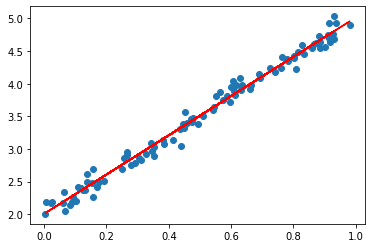

In [115]:
import matplotlib.pyplot as plt

xdata = np.random.rand(100, 1)
ydata = 3*xdata + 2 + np.random.randn(100, 1)/10

a = tf.Variable(0, dtype=tf.float64)
b = tf.Variable(0, dtype=tf.float64)
x = tf.constant(xdata, dtype=tf.float64)
yobs = tf.constant(ydata, dtype=tf.float64)

learning_rate = 0.05
for i in range(2000):
  with tf.GradientTape() as tape:
    y = a*x+b
    mse = tf.reduce_sum((y - yobs)**2/xdata.shape[0])
  da, db = tape.gradient(mse, [a, b])
  a.assign_sub(learning_rate*da)
  b.assign_sub(learning_rate*db)

del(tape)

plt.scatter(xdata, ydata)
plt.plot(xdata, a*xdata+b, 'r')

print(f"Fitted a = {a.numpy()}, b = {b.numpy()}")

## Introduction to CUDA